In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train/MEL 3308
data/train/DF 4152
data/train/BKL 3275
data/train/BCC 4773
data/train/VASC 3488
data/train/AKIEC 3856
data/train/NV 4975


In [5]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation/MEL 1664
data/validation/DF 1632
data/validation/BKL 1479
data/validation/BCC 1692
data/validation/VASC 1484
data/validation/AKIEC 1552
data/validation/NV 1730


In [6]:
from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [7]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [8]:
## Intilizing variables
output_classes = 7

batch_size = 32 
epochs = 50
droput_rate= 0.5

adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
resnet50_weights = 'pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
from keras.applications import ResNet50
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = (ResNet50(include_top=False, pooling='avg', weights=resnet50_weights))
x = model.output
# x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
model = Model(input = model.input, output = predictions)


model.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])


In [13]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 859s 420ms/step - loss: 1.3383 - categorical_accuracy: 0.6545 - fmeasure: 0.6494 - recall: 0.6096 - precision: 0.6994 - val_loss: 0.7505 - val_categorical_accuracy: 0.8207 - val_fmeasure: 0.8175 - val_recall: 0.7907 - val_precision: 0.8470
Epoch 2/50
2048/2048 [==============================] - 841s 411ms/step - loss: 0.5628 - categorical_accuracy: 0.8911 - fmeasure: 0.8922 - recall: 0.8793 - precision: 0.9060 - val_loss: 0.6494 - val_categorical_accuracy: 0.8692 - val_fmeasure: 0.8716 - val_recall: 0.8566 - val_precision: 0.8876
Epoch 3/50
2048/2048 [==============================] - 841s 411ms/step - loss: 0.3765 - categorical_accuracy: 0.9535 - fmeasure: 0.9535 - recall: 0.9491 - precision: 0.9580 - val_loss: 0.6264 - val_categorical_accuracy: 0.8854 - val_fmeasure: 0.8887 - val_recall: 0.8804 - val_precision: 0.8974
Epoch 4/50
2048/2048 [==============================] - 841s 411ms/step - loss: 0.2979 - categorical_accuracy: 0

Epoch 29/50
2048/2048 [==============================] - 838s 409ms/step - loss: 0.1734 - categorical_accuracy: 0.9991 - fmeasure: 0.9991 - recall: 0.9991 - precision: 0.9991 - val_loss: 0.5724 - val_categorical_accuracy: 0.9153 - val_fmeasure: 0.9159 - val_recall: 0.9135 - val_precision: 0.9184
Epoch 30/50
2048/2048 [==============================] - 838s 409ms/step - loss: 0.1711 - categorical_accuracy: 0.9990 - fmeasure: 0.9990 - recall: 0.9990 - precision: 0.9990 - val_loss: 0.5800 - val_categorical_accuracy: 0.9157 - val_fmeasure: 0.9165 - val_recall: 0.9146 - val_precision: 0.9185
Epoch 31/50
2048/2048 [==============================] - 841s 411ms/step - loss: 0.1675 - categorical_accuracy: 0.9993 - fmeasure: 0.9993 - recall: 0.9993 - precision: 0.9993 - val_loss: 0.5415 - val_categorical_accuracy: 0.9201 - val_fmeasure: 0.9214 - val_recall: 0.9195 - val_precision: 0.9234
Epoch 32/50
2048/2048 [==============================] - 840s 410ms/step - loss: 0.1638 - categorical_accurac

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  0.5092729738354683
Test Accuracy:  0.9275
fmeasure:  0.9274205827713012
Recall:  0.926875
Precision:  0.9279838705062866


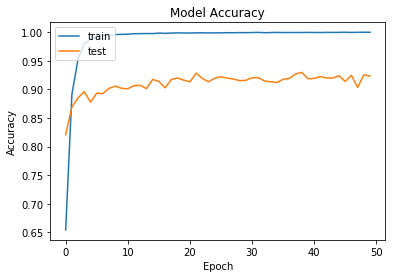

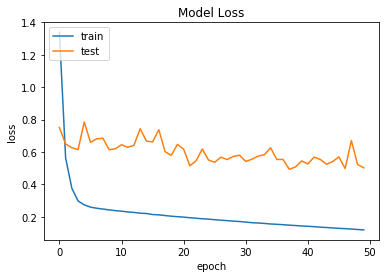

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

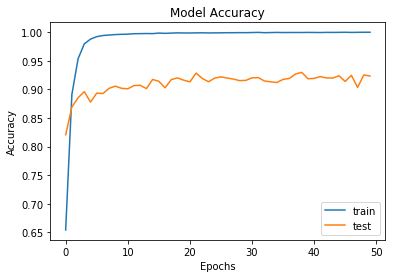

In [17]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

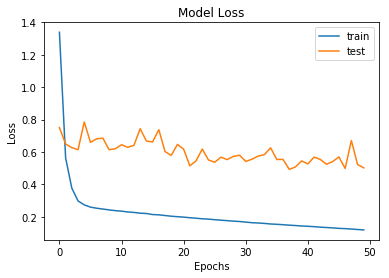

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

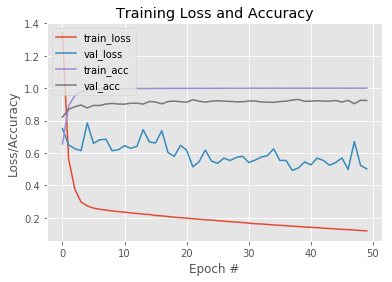

In [20]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [9]:
from keras.models import load_model
model = load_model("models/4.ResNet-Adam-Dropout-Model.h5", custom_objects={'fmeasure': fmeasure,  'recall': recall, 'precision': precision })
model.load_weights("models/4.ResNet-Adam-Dropout-Weights.h5")

In [10]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [11]:
predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 3127s 9s/step
No of errors = 890/11233


Confusion Matrix
[[1421   34   61    1   23   12    0]
 [   8 1662   10    0    9    3    0]
 [   7    8 1431    0   18   15    0]
 [  16   78   21 1499    6   12    0]
 [   3    5   33    0 1517  106    0]
 [   2   12   27    1   35 1651    2]
 [  12    1  279   15   10    5 1162]]


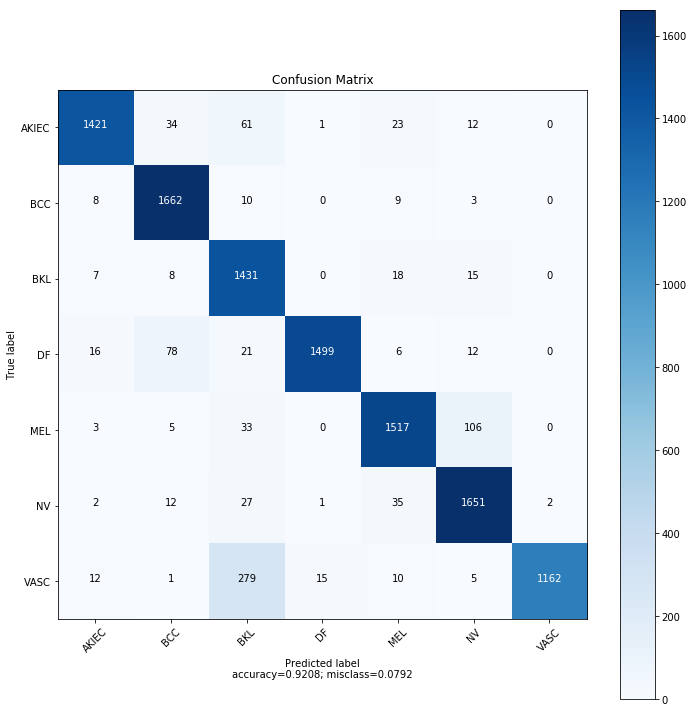

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))    

plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

Confusion matrix
[[1421   34   61    1   23   12    0]
 [   8 1662   10    0    9    3    0]
 [   7    8 1431    0   18   15    0]
 [  16   78   21 1499    6   12    0]
 [   3    5   33    0 1517  106    0]
 [   2   12   27    1   35 1651    2]
 [  12    1  279   15   10    5 1162]]


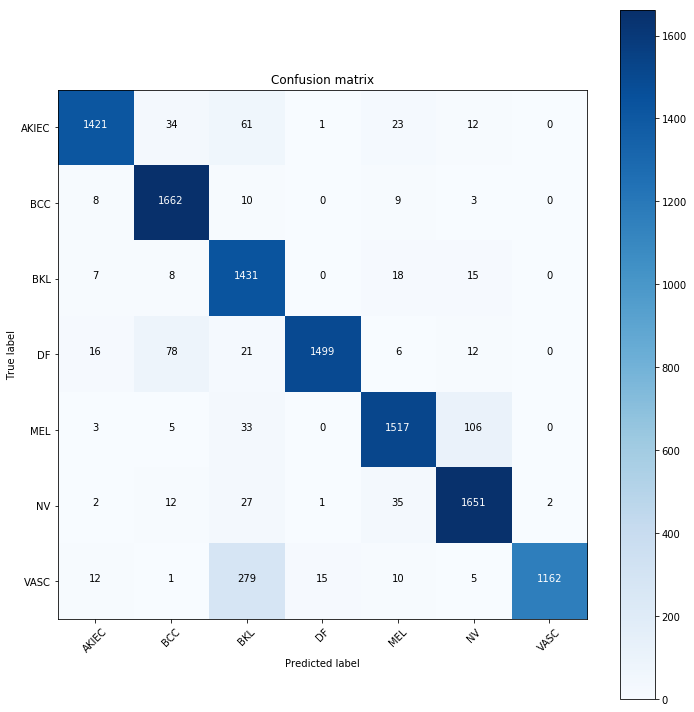

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix')

In [24]:
model.save('models/4.ResNet-Adam-Dropout-Model.h5')
model.save_weights('models/4.ResNet-Adam-Dropout-Weights.h5')

In [25]:
import numpy as np